### Contents
1 - Highlight dial area from larger photo <br>
2 - Align other dial based on template <br>
3 - Trial SSM similarity measure <br>

#### TODO:
i. hough transform: adjust parameter if no circle found <br>
ii. blob detection: alternative approach to hough transform <br>
iii. todo: transf

### 1 - Crop circular dial region from larger photo:

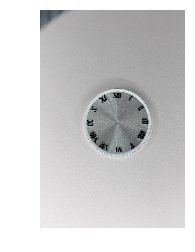

/Users/franzr/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


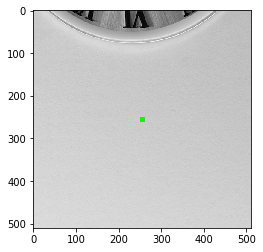

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim
from skimage import io
from skimage.filters import threshold_mean, gaussian
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb, rgb2gray, rgb2lab
import matplotlib.patches as mpatches

# grayscale conversion for cv functions:
def gray(pic):
    return cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

def quick_fig(img):
    plt.figure(figsize=(16,5)) 
    plt.imshow(img)
    plt.axis("off")
    
# import 
# img = cv2.imread("sample/bad/b1.jpg")
img = cv2.imread("Working_Copy/dail_photos/s3/g/g0.JPG")
# img = cv2.imread("Working_Copy/dail_photos/s3/ng/IMG_9816.JPG")
plt.axis("off")
plt.imshow(img)
plt.show()

def crop_circular_region(orig, use_mask=False, draw_outline=False, fixed_rect_size=255, rect_padding=10):
    """
    return largest circular region corresponding to watch dial
    """
    img_hough = gray(orig)
    # smooth image to make sure smaller features don't get captured as circles
    img_hough = img_as_ubyte(gaussian(img_hough, sigma=0.0))
    # ...and detect circles. 
    circ = cv2.HoughCircles(img_hough, cv2.cv.CV_HOUGH_GRADIENT, 1.4, 100)
    if circ is not None:
        circ = circ.squeeze()
        # sort potentially multiple circles and pick largest (by radius) as dial surface:
        if circ.size > 3:
            circ = circ[np.argmax(circ[:,2])]
        x,y,rad = circ.astype(int)
        img_hough = gray2rgb(img_hough)
        if use_mask: 
            # mask image outside circle, classifier should only pay attention to dial surface:
            yy,xx = np.ogrid[0:img_hough.shape[0], 0:img_hough.shape[1]]
            mask = (xx-x)**2 + (yy-y)**2 >= rad**2
            img_hough[mask] = (0,0,0)
        if draw_outline:
            # draw circle & center
            cv2.circle(img_hough, (x, y), rad, (0,255,0), 4)
            cv2.rectangle(img_hough, (x - 5, y - 5), (x + 5, y + 5), (0,255, 0), -1)
        # cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        if not fixed_rect_size:
            rect_size = rad + rect_padding
            cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        else:
            cropped_rect = img_hough[y-fixed_rect_size:y+fixed_rect_size, x-fixed_rect_size:x+fixed_rect_size]
        return cropped_rect
    else: 
        raise ValueError("No circular region found, consider adjusting hough parameters")

# saved_rect = crop_circular_region(img, use_mask=True, draw_outline=True)
saved_rect = crop_circular_region(img, use_mask=False, draw_outline=True)

smpath = "sample/bad/"
for f in os.listdir(smpath):
    # print f
    pass
    # crp = img_as_ubyte(crop_circular_region(cv2.imread(smpath+f)))
    ### io.imsave("good_cropped/" + f[:-3]+"png", crp)
io.imsave("POON1.png", saved_rect)
# quick_fig(np.hstack([img, img_hough]))
plt.imshow(saved_rect)
plt.show()


### 1b - Alternate approach: segment out largest blob / contour

In [3]:
from skimage import measure
from skimage.filters import try_all_threshold, threshold_triangle 
# from skimage.restoration import denoise_tv_chambolle
from skimage.morphology import erosion, opening, disk
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.color import label2rgb
from skimage import transform

print "completed imports"
# orig = io.imread("Working_Copy/dail_photos/s3/ng/n0.JPG")
# orig = io.imread("Working_Copy/dail_photos/s3/g/IMG_9810.JPG")
# orig = io.imread("Working_Copy/dail_photos/s3/g/IMG_9816.JPG")
# orig = io.imread("Working_Copy/dail_photos/s2/ng/IMG_9802.JPG")
# anfang = io.imread("Working_Copy/dail_photos/s3/ng/IMG_9816.JPG")
anfang = io.imread("Working_Copy/dail_photos/s3/ng/IMG_9817.JPG")

quick_fig(orig)
print "completed load of image"
# resize (with scaling info to make thresholding easier afterwards)
def resize_with_scaling(img, single_factor=0.5, r_shape=None):
    orig_x, orig_y = img.shape[:2]
    if r_shape is not None:
        new_x, new_y = r_shape
        x_sf = orig_x*1.0/new_x
        y_sf = orig_y*1.0/new_y
    else:
        new_x = int(orig_x * 1.0 *single_factor)
        new_y = int(orig_y * 1.0 * single_factor)
        x_sf, y_sf = (single_factor, single_factor)
    resized = transform.resize(img, (new_x, new_y))
    return resized, (x_sf, y_sf)

def scale_label(label, scaling_factors):
    x,y = label
    x_sf, y_sf = scaling_factors
    x_new = int(x*1.0/x_sf)
    y_new = int(y*1.0/y_sf)
    return (x_new, y_new)

orig, scaling_factors = resize_with_scaling(anfang, 0.3)
print orig.shape
print "completed resize"

struct_elem_size = max(5,int(0.005*orig.shape[0]))
print struct_elem_size
elem = disk(struct_elem_size)
# triangle threshold on lab space image (3rd channel :,:,2) works well for most types
orig_gr = rgb2lab(orig)
orig_gr = (orig_gr + [0, 128, 128]) / [100, 255, 255]
orig_gr = orig_gr[:,:,2]
thresh = threshold_triangle(orig_gr)
binary = orig_gr > thresh
quick_fig(binary)
print "completed thresholding"
# binary = opening(binary, elem)


###

# remove artifacts connected to image border
cleared = clear_border(binary)

# label image regions
label_image = label(binary)
image_label_overlay = label2rgb(label_image, image=label_image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

print "completed opening/closing and stuff"   

crop_bbox = None
for region in regionprops(label_image):
    # take regions with large enough areas 
    # usually 500*500 pixel on 1200*1920 images -> 400*400
    # if region.area >= 400*400:
    # or % area wise: >7% area
    overall_area = label_image.shape[:2][0]*label_image.shape[:2][1]
    # print overall_area, 0.05*overall_area
    if region.area >= 0.05*overall_area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        crop_bbox = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        
if crop_bbox is not None:
    minr, minc, maxr, maxc = crop_bbox
    # cropped_region = orig[minr:maxr, minc:maxc]
    ####
    minr, minc = scale_label((minr, minc), (0.3, 0.3))
    maxr, maxc = scale_label((maxr,maxc), (0.3, 0.3))
    cropped_region = anfang[minr:maxr, minc:maxc]
    quick_fig(cropped_region)
    # cropped_region = transform.resize(cropped_region, (510,510))
    # io.imsave("Working_Copy/dail_photos/s2/comp/template_hd.png", cropped_region)
ax.set_axis_off()
plt.tight_layout()
plt.show()


###
#plt.imshow(binary)
#plt.show()

completed imports


NameError: name 'orig' is not defined

In [41]:
print cropped_region.shape
cropped_region = transform.resize(cropped_region, (1000,1000))
io.imsave("Working_Copy/dail_photos/s3/comp/bad_vhd_2.png", cropped_region)

(1683, 1707, 3)


(500, 500, 3)


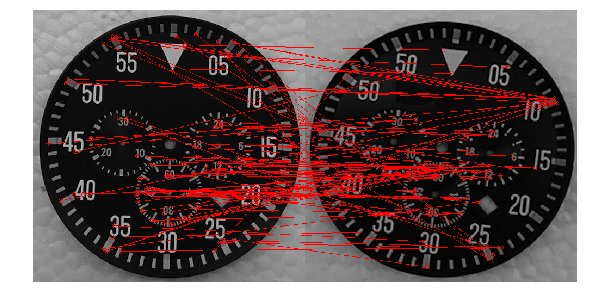

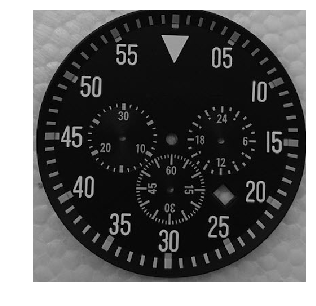

In [35]:
# export black dials:
black_good = cv2.imread("sample/black_dials/good.png")
black_bad = img = cv2.imread("sample/black_dials/bad.png")

print black_good.shape
def wop(orig, use_mask=False, draw_outline=False, fixed_rect_size=None, rect_padding=10):
    """
    return largest circular region corresponding to watch dial
    """
    if len(orig.shape)>2:
        img_hough = gray(orig)
    else:
        img_hough = orig
    # smooth image to make sure smaller features don't get captured as circles
    img_hough = img_as_ubyte(gaussian(img_hough, sigma=0.0))
    # ...and detect circles. 
    circ = cv2.HoughCircles(img_hough, cv2.cv.CV_HOUGH_GRADIENT, 1.4, 100)
    if circ is not None:
        circ = circ.squeeze()
        # sort potentially multiple circles and pick largest (by radius) as dial surface:
        if circ.size > 3:
            circ = circ[np.argmax(circ[:,2])]
        x,y,rad = circ.astype(int)
        img_hough = gray2rgb(img_hough)
        if use_mask: 
            # mask image outside circle, classifier should only pay attention to dial surface:
            yy,xx = np.ogrid[0:img_hough.shape[0], 0:img_hough.shape[1]]
            mask = (xx-x)**2 + (yy-y)**2 >= rad**2
            img_hough[mask] = (0,0,0)
        if draw_outline:
            # draw circle & center
            cv2.circle(img_hough, (x, y), rad, (0,255,0), 4)
            cv2.rectangle(img_hough, (x - 5, y - 5), (x + 5, y + 5), (0,255, 0), -1)
        # cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        if not fixed_rect_size:
            rect_size = rad + rect_padding
            cropped_rect = img_hough[y-rect_size:y+rect_size, x-rect_size:x+rect_size]
        else:
            cropped_rect = img_hough[y-fixed_rect_size:y+fixed_rect_size, x-fixed_rect_size:x+fixed_rect_size]
        return cropped_rect
    else: 
        raise ValueError("No circular region found, consider adjusting hough parameters")

cropped_good = wop(black_good)
io.imsave("b1.png", saved_rect)
quick_fig(cropped_good)
plt.show()

### 2 - Align dial to template 
Calculate rotation/transformation to get standard dial position for later classification

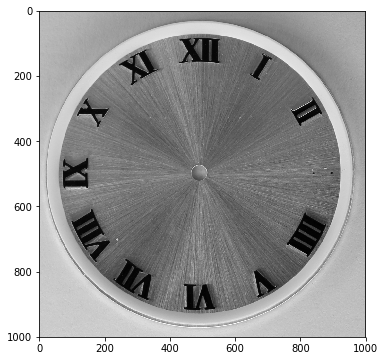

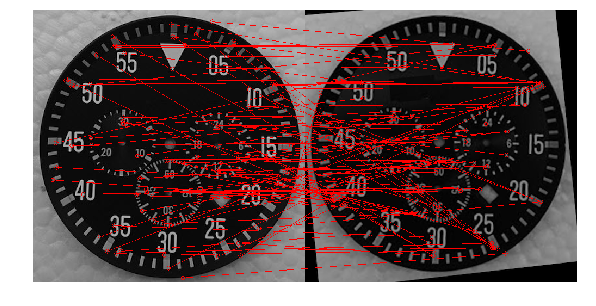

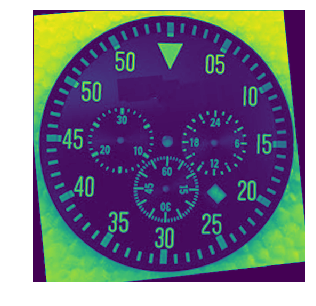

In [33]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    Helper function for drawing image alignment feature matches (taken from opencv 3
    as not supported in cv 2.4)
    """
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype="uint8")

    # Place the first image to the left
    out[:rows1, :cols1] = np.dstack([img1])

    # Place the next image to the right of it
    out[:rows2, cols1:] = np.dstack([img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)
    return out

def calculate_sift_matches(img1, img2, min_matches=10, n_matches=100):
    """
    Take 2 images, calculate matching features and return comparison img + inverse transformation matrix
    """
    # Initiate SIFT detector
    sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    MIN_MATCH_COUNT = min_matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    bf = cv2.BFMatcher()
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # matches = bf.knnMatch(des1,des2, k=2)
    # store good matches
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        inverse_transformation = np.linalg.inv(M)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        tup = tuple(np.int32(dst)[1,0])
        # cv2.circle(img2, tup, 30, color=(0,255,0))
        # rectangle to visualise transform matrix
        ### 
        # cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5, cv2.CV_AA)
    else:
        print "Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT)
        matchesMask = None
        """
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
        """
    # draw a max. of n_matches in the visualisation
    img3 = drawMatches(img1,kp1,img2,kp2,good_matches[:n_matches])
    return img3, inverse_transformation


## img = gray(cv2.imread("good_cropped/masked/g6.png"))
## bad = gray(cv2.imread("good_cropped/masked/b3.png"))
img = gray(cv2.imread("sample/black_dials/good.png"))
bad = gray(cv2.imread("sample/black_dials/macho_libre.png"))

# try on single rotated image & ensemble image
# matched_rot_img, _ = calculate_sift_matches(img, img_rotated)
matched_ensemble_img, inv_m = calculate_sift_matches(img, bad)

recalibrated = cv2.warpPerspective(bad, inv_m, (510, 510))
quick_fig(matched_ensemble_img)
io.imsave("sample_match.png", recalibrated)
quick_fig(recalibrated)
plt.show()


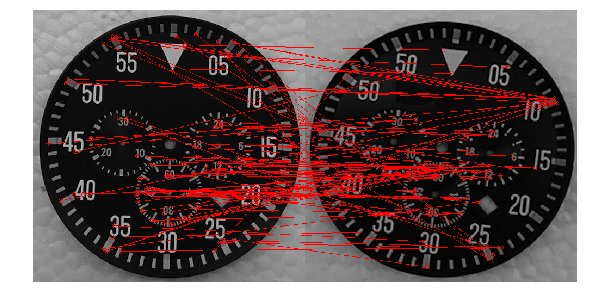

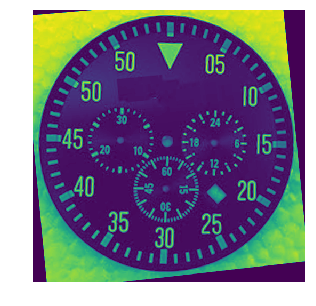

In [37]:
godo = gray(cv2.imread("sample/black_dials/good.png"))
bado = gray(cv2.imread("sample/black_dials/bad.png"))

# try on single rotated image & ensemble image
# matched_rot_img, _ = calculate_sift_matches(img, img_rotated)
MATCHO, INV_BLACK = calculate_sift_matches(godo, bado)

RECO = cv2.warpPerspective(bado, INV_BLACK, (510, 510))
quick_fig(MATCHO)
WECO = wop(RECO)
quick_fig(RECO)
io.imsave("macho_libre.png", RECO)
plt.show()

### 3 - Similarity Measure & Image comparison
These attempts didn't work as well due to offsets even with good image alignment.

(510, 510, 3) (510, 510, 3)


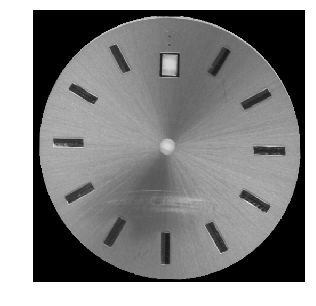

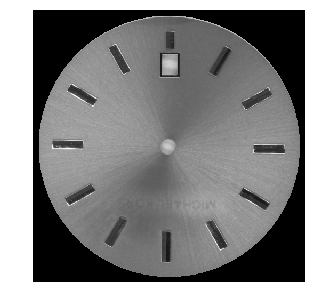

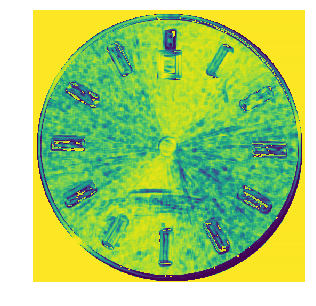

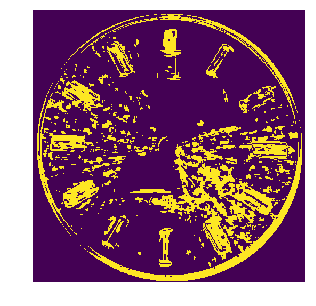

In [35]:
# load the two input images
imageA = cv2.imread("sample_match.png")
# imageA = cv2.imread("good_cropped/g1.png")
imageB = cv2.imread("good_cropped/masked/g6.png")

print imageA.shape, imageB.shape
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
# print("SSIM: {}".format(score))



# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] 

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    #print (x,y,w,h)
    # cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(grayB, (x, y), (x + w, y + h), (0, 0, 255), 2)

# show the output images
quick_fig(imageA)
quick_fig(imageB)
quick_fig(diff)
quick_fig(thresh)
plt.show()

### 4. Excursion: try feature matching for detecting out-of-place roman chars

In [143]:
# start from this cell if want to import from text file
with open("watch_labels_roman_hd.txt","r") as readfile:
    dr = []; gen = []; br = [];
    for line in readfile.readlines():
        lit = line.replace("\n","").split(";")
        # print lit
        vals = [float(n) for n in lit[:2]]
        if lit[2] == "digit":
            dr.append(vals)
        elif lit[2] == "roi":
            gen.append(vals)
        elif lit[2] == "background":
            br.append(vals)

Not enough matches are found - 0/3
not enough matches found
Not enough matches are found - 0/3
not enough matches found
Not enough matches are found - 1/3
not enough matches found
Not enough matches are found - 3/3
not enough matches found
Not enough matches are found - 2/3
not enough matches found
not enough matches found
Not enough matches are found - 3/3
not enough matches found
Not enough matches are found - 2/3
not enough matches found


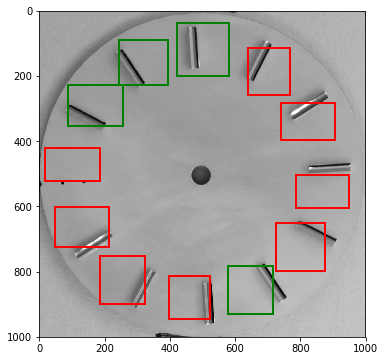

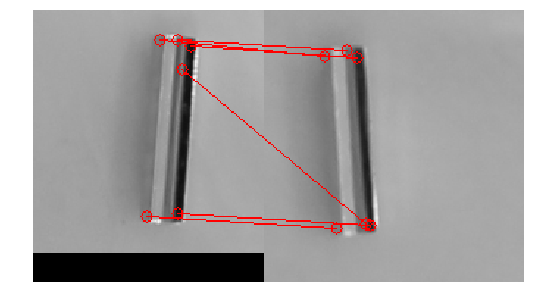

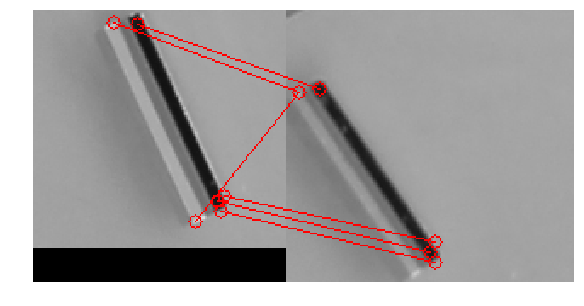

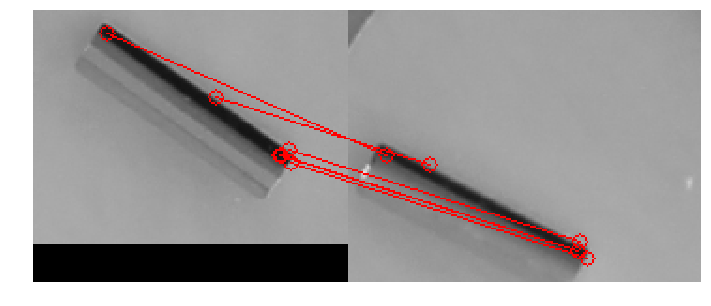

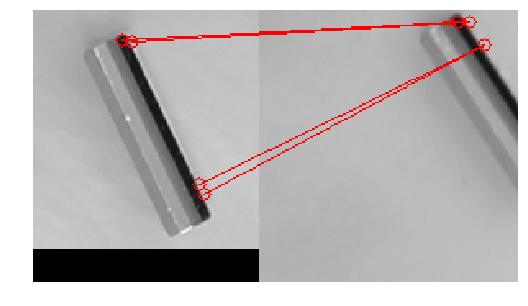

In [258]:
good = gray(cv2.imread("Working_Copy/dail_photos/s2/comp/template_hd.png"))
bad = gray(cv2.imread("Working_Copy/dail_photos/s2/comp/bad_hd.png"))
# img = rgb2gray(img)
gen = [[int(x),int(y)] for [x,y] in gen]

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bad, cmap="gray")

for i in range(0, len(gen)- len(gen)%2, 2):
    try:
        x1,y1 = gen[i]
        x2,y2 = gen[i+1]
        x1 = min(x1,x2)
        x2 = max(x2,x2)
        y1 = min(y1,y2)
        y2 = max(y1,y2)
        # img[y1:y2, x1:x2] = 0
        g_temp = good[y1:y2, x1:x2]
        b_temp = bad[y1-10:y2+10, x1-10:x2+10]
        matched_ensemble_img, inv_m = calculate_sift_matches(g_temp, b_temp, min_matches=3)
        rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        quick_fig(matched_ensemble_img)
    except Exception:# UnboundLocalError:
        rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        print "not enough matches found"
#matched_ensemble_img, inv_m = calculate_sift_matches(template, bad)
# quick_fig(matched_ensemble_img)
plt.show()

In [44]:
# start from this cell if want to import from text file
# with open("watch_labels_roman_hd.txt","r") as readfile:
with open("watch_labels_dumb_roman.txt","r") as readfile:
    dr = []; gen = []; br = [];
    for line in readfile.readlines():
        lit = line.replace("\n","").split(";")
        # print lit
        vals = [float(n) for n in lit[:2]]
        if lit[2] == "digit":
            dr.append(vals)
        elif lit[2] == "roi":
            gen.append(vals)
        elif lit[2] == "background":
            br.append(vals)

(1000, 1000) (1000, 1000)
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found
not enough matches found


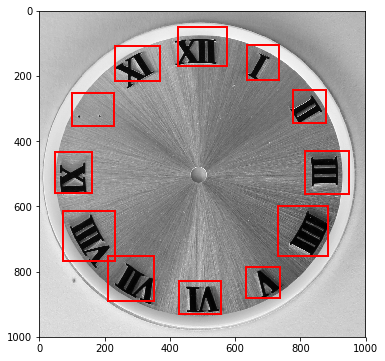

In [5]:
#good = gray(cv2.imread("sample/black_dials/good.png"))
#bad = gray(cv2.imread("sample_match.png"))

good = gray(cv2.imread("Working_Copy/dail_photos/s3/comp/good_vhd.png"))
bad = gray(cv2.imread("Working_Copy/dail_photos/s3/comp/bad_vhd_2.png"))

#good = gray(cv2.imread("sample/more_roman/good_roman.png"))
#bad = gray(cv2.imread("sample/more_roman/bad_roman.png"))

# img = rgb2gray(img)
gen = [[int(x),int(y)] for [x,y] in gen]

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bad, cmap="gray")
 
for i in range(0, len(gen)- len(gen)%2, 2):
    try:
        x1,y1 = gen[i]
        x2,y2 = gen[i+1]
        x1 = min(x1,x2)
        x2 = max(x2,x2)
        y1 = min(y1,y2)
        y2 = max(y1,y2)
        # img[y1:y2, x1:x2] = 0
        rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2)
        g_temp = good[y1:y2, x1:x2]
        b_temp = bad[y1:y2, x1:x2]
        # print i
        matched_ensemble_img, inv_m = calculate_sift_matches(g_temp, b_temp, min_matches=3)
        # ax.add_patch(rect)
        quick_fig(matched_ensemble_img)
    except Exception:
        rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        print "not enough matches found"
#matched_ensemble_img, inv_m = calculate_sift_matches(template, bad)
# quick_fig(matched_ensemble_img)
plt.show()

Not enough matches are found - 1/5
Not enough matches are found - 2/5
Not enough matches are found - 4/5
Not enough matches are found - 0/5
Not enough matches are found - 3/5
Not enough matches are found - 2/5


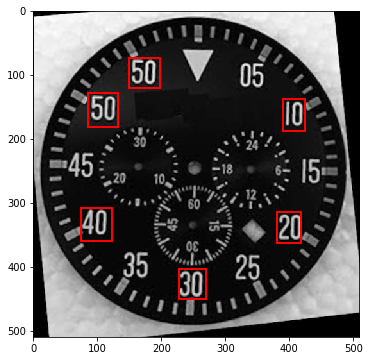

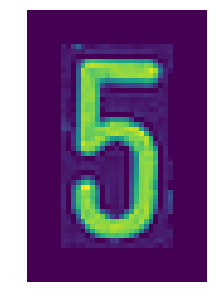

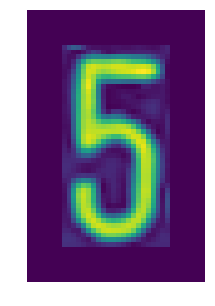

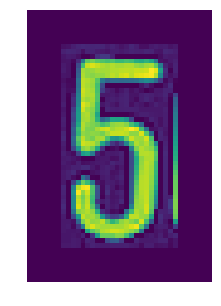

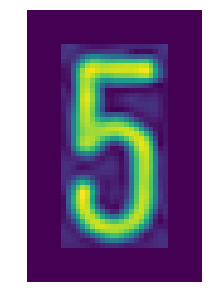

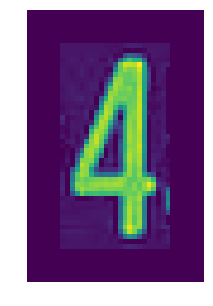

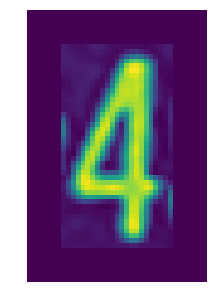

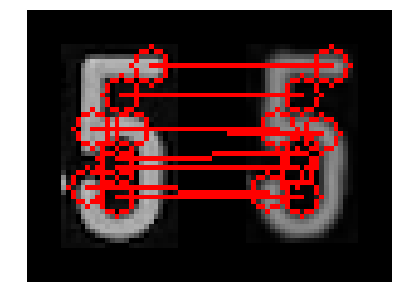

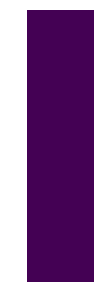

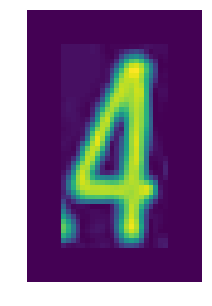

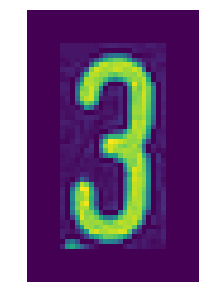

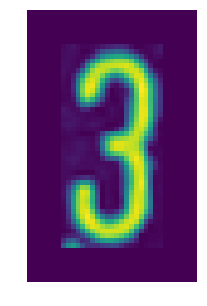

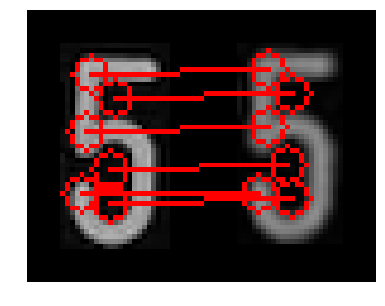

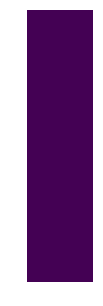

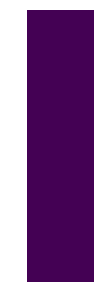

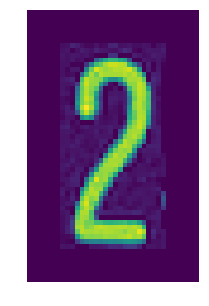

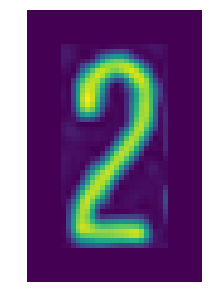

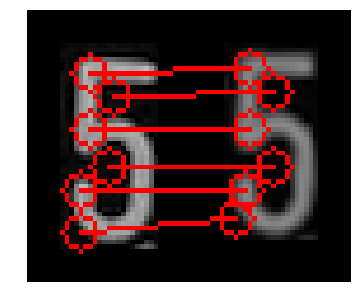

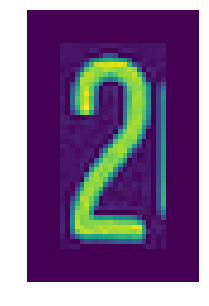

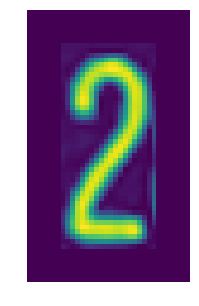

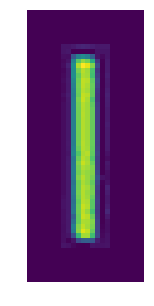

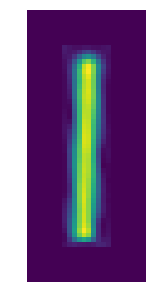

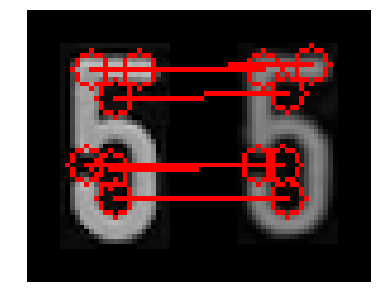

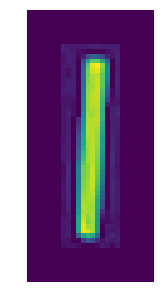

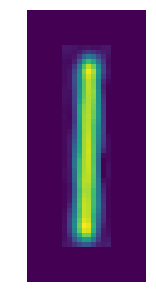

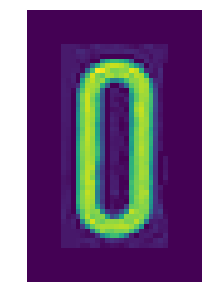

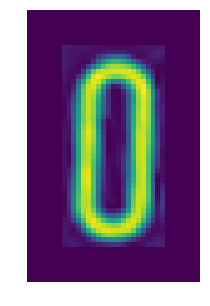

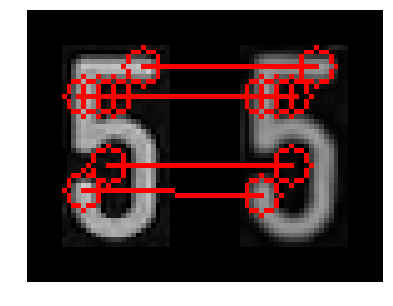

In [317]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def preprocess_digits(roi):
    """
    Blurs and thresholds a roi, returns list of image sections potentially containing digits
    as numpy arrays; reformatted to 28*28 for MNIST-style digit recognition
    """
    regions = []
    small = roi.copy()
    if len(small.shape) > 2:
        small = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    # small = cv2.medianBlur(small,3)
    _, small = cv2.threshold(small,100, 255,cv2.THRESH_BINARY)
    cnts = cv2.findContours(small.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for cn in cnts:
        # compute the bounding box of the contour and draw it on our
        # image
        (x, y, w, h) = cv2.boundingRect(cn)
        # check that the bounding box of the putative number takes up at least 5% of roi area:
        if w*h*1.0/(small.shape[0]*small.shape[1]) > 0.05:
            potential_digit = roi.copy()[y-3:y+h+2, x-3:x+w+3]
            potential_digit = cv2.copyMakeBorder(potential_digit,7,7,7,7,cv2.BORDER_CONSTANT)#,value=np.minimum(potential_digit))
            # potential_digit = cv2.resize(potential_digit, (28,28))
            regions.append(potential_digit)
    return regions

def cycle_over_digit_rois(img, img2, roi_list, comparison_list=None):
    """
    Cycle over coordinate list of digit-containing regions on image and return
    dictionary of probable numeric values
    """
    indep = 0
    digit_predictions = []
    # split up list into twos (may change later)
    for i in range(0, len(roi_list)- len(roi_list)%2, 2):
        x1,y1 = [int(n) for n in roi_list[i]]
        x2,y2 = [int(n) for n in roi_list[i+1]]
        # xmid= int(x1+(x2-x1)/2)
        sub_roi_1 = img.copy()[y1:y2,x1:x2]
        sub_roi_2 = img2.copy()[y1:y2,x1:x2]
        digits_1 = preprocess_digits(sub_roi_1)
        digits_2 = preprocess_digits(sub_roi_2)
        # quick_fig(np.hstack([digits_1, digits_2]))
        quick_fig(digits_1[0])
        quick_fig(digits_2[0])
        try:
            # matched_ensemble_img, inv_m = calculate_sift_matches(digits_1[0], digits_2[0], min_matches=4)
            matched_ensemble_img, inv_m = calculate_sift_matches(digits_1[1], digits_2[1], min_matches=5)
            quick_fig(matched_ensemble_img)
        except UnboundLocalError:
            rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    # return digit_predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bad, cmap="gray")
cycle_over_digit_rois(good, bad, dr, None)
plt.show()
# print "good dial:" , good_recog
#bad_recog = cycle_over_digit_rois(bd, dr, good_recog)
#print "bad dial:", bad_recog

# print time.time() - begin

# print pytesseract.image_to_string(Image.open('tess_work.png'))
# quick_fig(bd)

#### next trial: iterative same-pattern matching for roman numeral

In [48]:
#...to be continued...

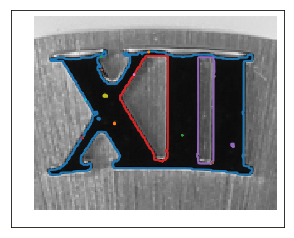

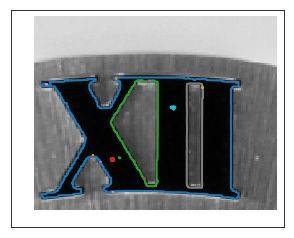

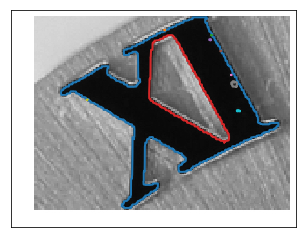

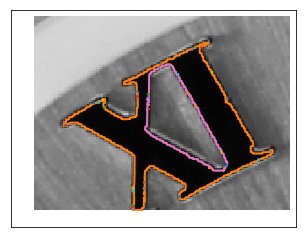

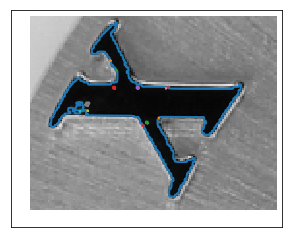

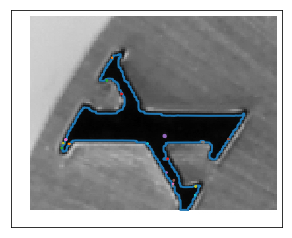

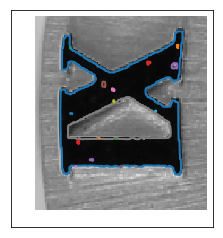

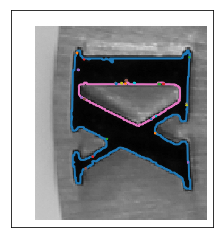

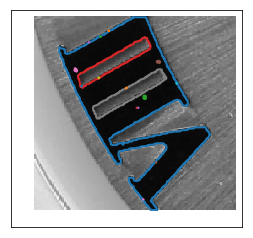

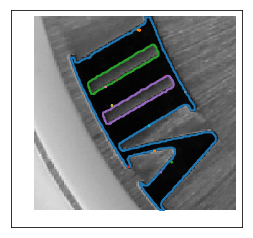

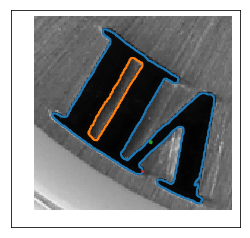

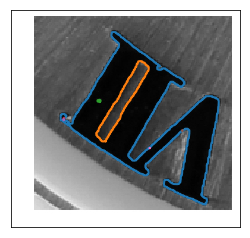

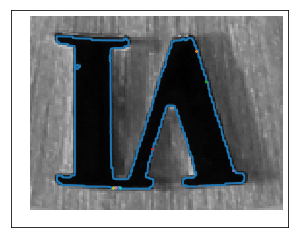

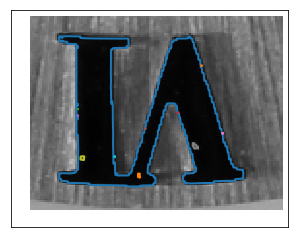

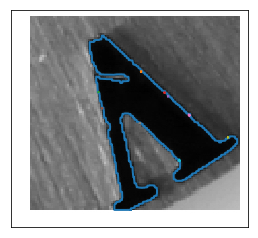

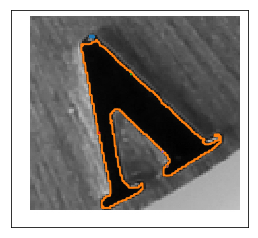

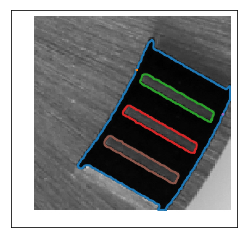

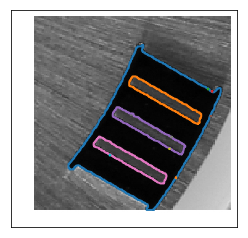

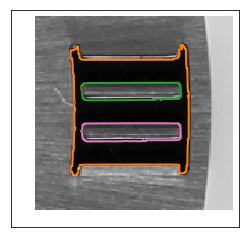

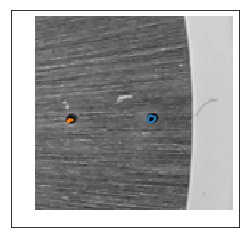

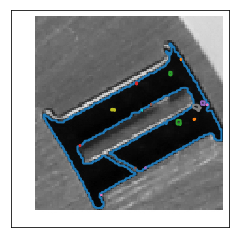

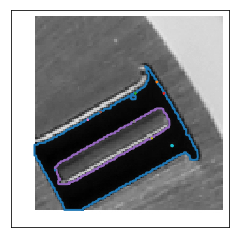

In [30]:
# https://docs.opencv.org/3.4.1/d1/d32/tutorial_py_contour_properties.html

for i in range(11): #[1,3]:    range(12):
    n1 = io.imread("roman/download-{}.jpg".format(i))
    n2 = io.imread("roman/alternative-{}.jpg".format(i))
    #n1 = io.imread("roman/marks/download-{}.jpeg".format(i))
    #n2 = io.imread("roman/marks/a-{}.jpeg".format(i))
    #n1 = io.imread("roman/numbers/download-{}.jpeg".format(i))
    #n2 = io.imread("roman/numbers/alternative-{}.jpeg".format(i))
    def show_contours(sic):
        # quick_fig(sic)
        pic = rgb2gray(sic.copy())
        #pic = (pic + [0, 128, 128]) / [100, 255, 255]
        #pic = pic[:,:,2]
        fig, ax = plt.subplots()
        ax.imshow(pic, interpolation='nearest', cmap=plt.cm.gray)
        contours = measure.find_contours(pic, 0.1)
        for n, contour in enumerate(contours):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        return contours

    c1 = show_contours(n1)
    c2 = show_contours(n2)
    """
    def convert_contours(contours):
        converted = []
        # mask = np.zeros_like(toral)
        for n, contour in enumerate(contours):
            # append contour with empty dimension for cv2 compatibility
            c_conv = np.expand_dims(np.fliplr(contour), axis=1).astype(np.int32)
            if cv2.contourArea(c_conv) > 6000:
                converted.append(c_conv)
        return converted

    conv1 = convert_contours(c1)
    conv2 = convert_contours(c2)

    def show_contour_props(cnt):
        area = cv2.contourArea(cnt)
        x,y,w,h = cv2.boundingRect(cnt)
        (x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
        aspect_ratio = float(MA)/ma
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        return [area, aspect_ratio, angle, solidity]

    props1 = [show_contour_props(c) for c in conv1]
    props2 = [show_contour_props(c) for c in conv2]

    print "{}, area:{}, aspect ratio:{}, angle:{}, solidity: {}".format(i, *props1[0])
    print "{}, area:{}, aspect ratio:{}, angle:{}, solidity: {}".format(i, *props2[0])
    # deltas = []
    # for g in range(len(props1[0])):
        # print 1.0*props1[0][g] - props2[0][g]#  / 1.0*props1[0][g]
        # print props2[0][g] # 1.0*props1[0][g]
    # print "d_ar:{}, d_aspect ratio:{}, d_angle:{}, d_solidity: {}".format(*deltas)
    """
    plt.show()
    # print props2
    
# plt.show()
